### Project Overview:

The model is designed to classify emails as 'Ham' (0) or 'Spam' (1)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
data = pd.read_csv('sample_data/spam.csv')
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Check the size of the dataset (number of rows and columns)
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

Dataset contains 5572 rows and 2 columns.


In [ ]:
# Check for Missing Values
# Ensures the dataset is complete before proceeding.
data.isna().sum()

,0
Category,0
Message,0


In [ ]:
# Create binary Spam column
# Converts 'Category' to binary labels: 1 for spam, 0 for ham.
data['Spam'] = data['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
# Check class distribution
print("\nClass Distribution:")
print(data['Spam'].value_counts(normalize=True))


Class Distribution:
Spam
0    0.865937
1    0.134063
Name: proportion, dtype: float64


There is class imbalance (Ham: ~86.6%, Spam: ~13.4%), which can bias the model toward Ham.


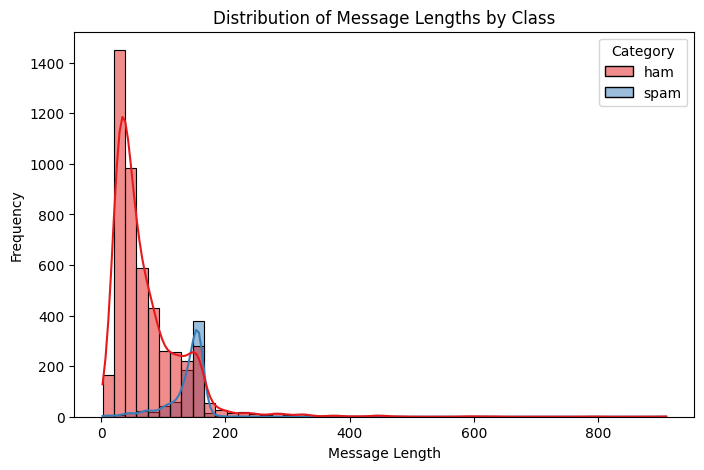

In [ ]:
# Check message lengths
data['text_length'] = data['Message'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=data, x='text_length', hue='Category', bins=50, palette='Set1', kde=True)
plt.title('Distribution of Message Lengths by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


Observation:

Ham messages (in red) tend to cluster around shorter lengths (10–100 characters).

Spam messages (in blue) have more variation, with some being longer (above 100 characters).


Usefulness:

Message length could be a predictive feature in classifying spam vs. ham.

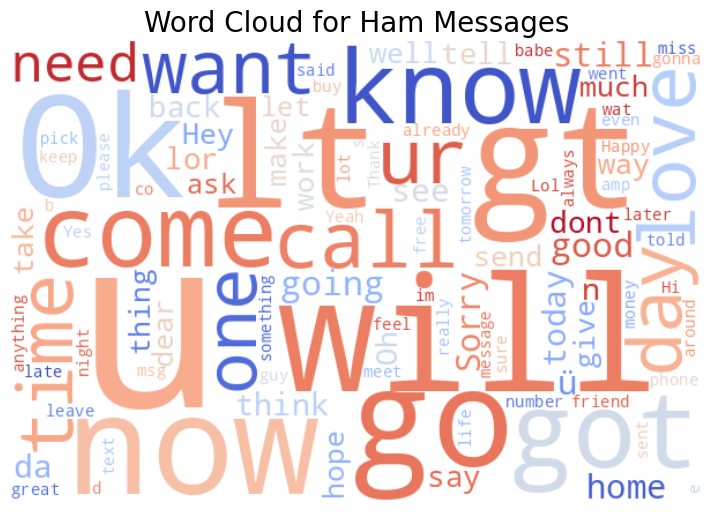

In [ ]:
# Generate WordCloud for Ham messages
ham_words = ' '.join(data[data['Category'] == 'ham']['Message'])

ham_wc = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='coolwarm',
    max_words=100,
    contour_color='steelblue',
).generate(ham_words)

plt.figure(figsize=(10,6))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages', fontsize=20)
plt.show()

Observation:

Words like "ok", "come", "know", "call", "go", and "love" dominate.

Usefulness:

These are typical in friendly or conversational messages, differentiating them from spam.


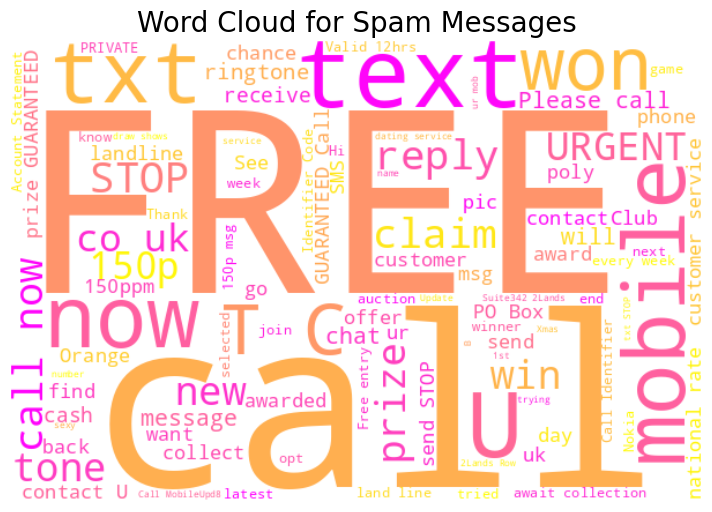

In [ ]:
# Generate WordCloud for Spam messages
spam_words = ' '.join(data[data['Category'] == 'spam']['Message'])

spam_wc = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='spring',
    max_words=100,
    contour_color='fuchsia',
).generate(spam_words)

plt.figure(figsize=(10,6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=20)
plt.show()

Observation:

Words like "FREE", "CALL", "NOW", "MOBILE", and "REPLY" are large, indicating they appear frequently in spam.

Usefulness:

These keywords help you understand common patterns in spam, useful for feature extraction or keyword-based filtering.


In [ ]:
# Preprocess text: lowercase and remove special characters
def preprocess_text(text):
    text = text.lower() # Convert to lowercase for consistency
    text = re.sub(r'[^a-z\s]', '', text) # Remove special characters, keep letters and spaces
    return text
data['Message'] = data['Message'].apply(preprocess_text)

In [ ]:
# Extract features and labels
X_raw = data['Message']
y = data['Category']

In [ ]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_raw)

In [ ]:
# Apply SMOTE to balance classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [ ]:
# Split Data into Training and Test Sets
# 75% train, 25% test split ensures sufficient data for training while reserving a test set for evaluation.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Model 1: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [ ]:
# Model 2: Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
# Model 3: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
# Evaluation Function
def evaluate_model(y_test, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label='spam'))
    print("Recall:", recall_score(y_test, y_pred, pos_label='spam'))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label='spam'))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


Model: Naive Bayes
Accuracy: 0.9880829015544041
Precision: 0.9841605068637803
Recall: 0.9914893617021276
F1 Score: 0.9878113407525172


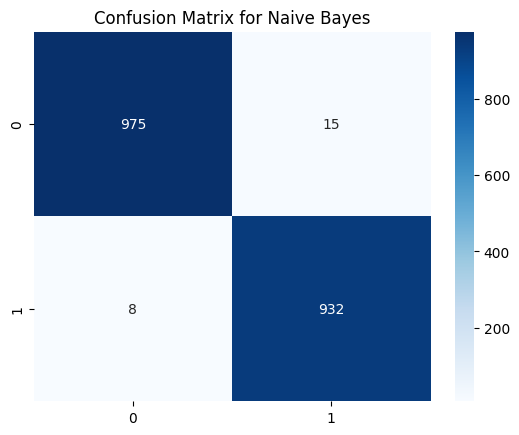


Model: Logistic Regression
Accuracy: 0.989119170984456
Precision: 0.992497320471597
Recall: 0.9851063829787234
F1 Score: 0.9887880405766151


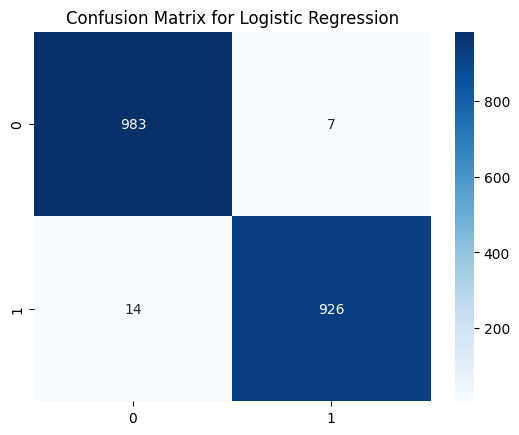


Model: Random Forest
Accuracy: 0.9922279792746114
Precision: 1.0
Recall: 0.9840425531914894
F1 Score: 0.9919571045576407


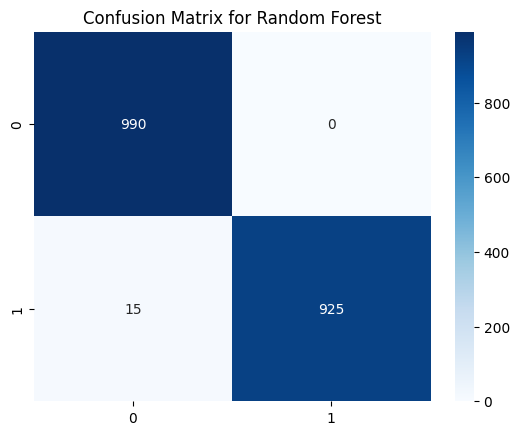

In [ ]:
# Evaluate all models
evaluate_model(y_test, y_pred_nb, "Naive Bayes")
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

In [ ]:
# Summary table
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb) * 100,
        accuracy_score(y_test, y_pred_lr) * 100,
        accuracy_score(y_test, y_pred_rf) * 100
    ],
    'Precision': [
        precision_score(y_test, y_pred_nb, pos_label='spam') * 100,
        precision_score(y_test, y_pred_lr, pos_label='spam') * 100,
        precision_score(y_test, y_pred_rf, pos_label='spam') * 100
    ],
    'Recall': [
        recall_score(y_test, y_pred_nb, pos_label='spam') * 100,
        recall_score(y_test, y_pred_lr, pos_label='spam') * 100,
        recall_score(y_test, y_pred_rf, pos_label='spam') * 100
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_nb, pos_label='spam') * 100,
        f1_score(y_test, y_pred_lr, pos_label='spam') * 100,
        f1_score(y_test, y_pred_rf, pos_label='spam') * 100
    ]
})

# Round all values to 2 decimal places
results = results.round(2)

print(results)


                 Model  Accuracy  Precision  Recall  F1 Score
0          Naive Bayes     98.81      98.42   99.15     98.78
1  Logistic Regression     98.91      99.25   98.51     98.88
2        Random Forest     99.22     100.00   98.40     99.20
